In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstats
from glob import glob
import numpy as np

In [5]:
example_data = pd.read_csv('ssrt_metrics/indiv_guesses.csv', index_col=0)
example_data.columns = example_data.columns.str.replace('SSRT_', '')
melt_df = pd.melt(example_data, id_vars=['SSD'], value_vars=['SSRT','w_guesses','w_graded'], var_name = 'assumed_go_dist', value_name='SSRT')

In [6]:
example_data

,SSRT,mean_SSD,p_respond,max_RT,mean_go_RT,mean_stopfail_RT,omission_count,omission_rate,go_acc,stopfail_acc,SSD,w_guesses,w_graded
0,439.0,50.0,0.377367,1351.0,539.522453,271.839523,0,0.0,NaN,NaN,50.0,292.268335,868.0
1,393.0,100.0,0.390753,1351.0,539.522453,303.589708,0,0.0,NaN,NaN,100.0,296.994804,679.0
2,355.0,150.0,0.433880,1351.0,539.522453,342.891014,0,0.0,NaN,NaN,150.0,296.284940,546.0
3,321.0,200.0,0.489767,1351.0,539.522453,389.128321,0,0.0,NaN,NaN,200.0,291.000000,472.0
4,304.0,250.0,0.595880,1351.0,539.522453,426.326376,0,0.0,NaN,NaN,250.0,287.000000,423.0
5,292.0,300.0,0.704367,1351.0,539.522453,455.995562,0,0.0,NaN,NaN,300.0,283.000000,398.0
6,285.0,350.0,0.800000,1351.0,539.522453,482.024435,0,0.0,NaN,NaN,350.0,281.000000,351.0
7,279.0,400.0,0.872107,1351.0,539.522453,499.253408,0,0.0,NaN,NaN,400.0,277.527413,343.0
8,278.0,450.0,0.924560,1351.0,539.522453,514.026455,0,0.0,NaN,NaN,450.0,278.000000,325.0
9,278.0,500.0,0.957973,1351.0,539.522453,521.818915,0,0.0,NaN,NaN,500.0,279.000000,302.0


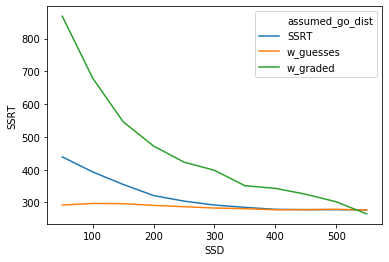

In [7]:
_ = sns.lineplot(x='SSD', y='SSRT', hue='assumed_go_dist', data=melt_df)

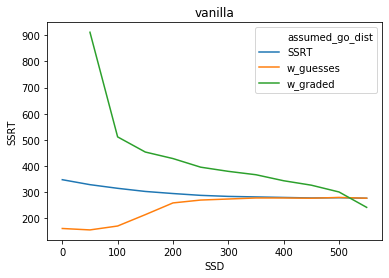

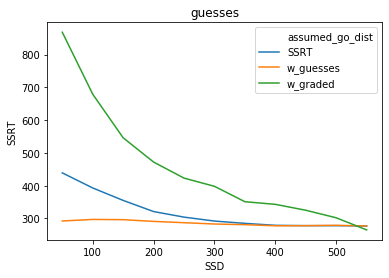

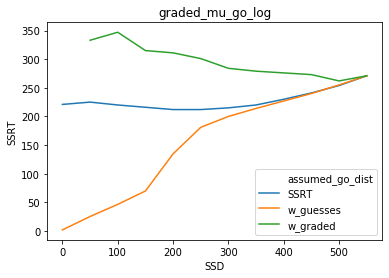

In [26]:
p_respond_df = pd.DataFrame(index = example_data.mean_SSD)

for file in [i for i in glob('ssrt_metrics/indiv_*.csv') if 'linear' not in i]:
    data =  pd.read_csv(file, index_col=0)
    data.columns = data.columns.str.replace('SSRT_', '')
    melt_df = pd.melt(data, id_vars=['SSD'], value_vars=['SSRT','w_guesses','w_graded'], var_name = 'assumed_go_dist', value_name='SSRT')
    _ = sns.lineplot(x='SSD', y='SSRT', hue='assumed_go_dist', data=melt_df)
    title = file.split('indiv_')[-1].replace('.csv', '')
    plt.title(title)
    plt.show()
    plt.close()
    
    curr_series = data.loc[:,['mean_SSD', 'p_respond']].set_index('mean_SSD').add_prefix(title+'_')
    p_respond_df = pd.concat([p_respond_df, curr_series], 1)

In [27]:
p_respond_df

,vanilla_p_respond,guesses_p_respond,graded_mu_go_log_p_respond
mean_SSD,,,
0.0,0.026533,NaN,0.000007
50.0,0.065813,0.377367,0.000953
100.0,0.138607,0.390753,0.010447
150.0,0.250480,0.433880,0.048193
200.0,0.393760,0.489767,0.135693
250.0,0.542927,0.595880,0.282473
300.0,0.680447,0.704367,0.466253
350.0,0.794147,0.800000,0.644200
400.0,0.871687,0.872107,0.792213
